!pip install dash dash-cytoscape

In [4]:
import os
import sys
import io
import re
import pickle
import gzip
import zipfile
import string
import json
from itertools import combinations
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

import dash
import dash_html_components as html
import dash_cytoscape as cyto

In [5]:
with gzip.open('../SampleDBs/df_yummly.pkl.gzip', 'rb') as f:
    df_yummly = pickle.load(f)

In [6]:
df_yummly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16781 entries, 0 to 16780
Data columns (total 7 columns):
flavors                11680 non-null object
id                     16781 non-null object
ingredients            16781 non-null object
recipeName             16781 non-null object
cuisine                16781 non-null object
PrepTime               16781 non-null float64
simpler_ingredients    16781 non-null object
dtypes: float64(1), object(6)
memory usage: 1.0+ MB


In [7]:
df_yummly.drop(['id',
                #'flavors', 
                'ingredients',
                'PrepTime'], axis=1, inplace=True)
df_yummly.head()

,flavors,recipeName,cuisine,simpler_ingredients
0,None,Healthier Red Thai Chicken Curry - without the...,thai,"[olive oil, chicken breast, chillies, ginger, ..."
1,"{'piquant': 0.16666666666666666, 'meaty': 0.16...",20 Minute Thai Basil Beef and Lemongrass Rice ...,thai,"[jasmine rice, coconut milk, water, toasted se..."
2,None,"Thai Pumpkin Laksa with Crunchy ""Fried"" Chickp...",thai,"[sesame oil, garlic, fresh ginger, seed, scall..."
3,"{'piquant': 0.5, 'meaty': 0.6666666666666666, ...",Thai Basil Chicken,thai,"[vegetable oil, sriracha sauce, crushed red pe..."
4,None,Skinny Thai Chicken Meatballs with Peanut Sauce,thai,"[ground chicken, scallion, chopped cilantro, f..."


In [10]:
df_yummly.flavors.dropna().reset_index(drop=True).loc[5]

{'piquant': 0.16666666666666666,
 'meaty': 0.6666666666666666,
 'bitter': 0.16666666666666666,
 'sweet': 0.16666666666666666,
 'sour': 0.8333333333333334,
 'salty': 0.16666666666666666}

In [11]:
df_yummly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16781 entries, 0 to 16780
Data columns (total 4 columns):
flavors                11680 non-null object
recipeName             16781 non-null object
cuisine                16781 non-null object
simpler_ingredients    16781 non-null object
dtypes: object(4)
memory usage: 655.5+ KB


### Decreasing names' sizes

In [16]:
#stopwords = ['the', 'in', 'one', 'of', 'and', 'with', 'without', 'shopbought', 'healthier', 'skinny']
def clean(text):
    text = re.sub(r'([^a-zA-Z ]+)', '', text)
    #for word in stopwords:
    text = re.sub(r'\b(the|in|one|of|and|with|without|shopbought|healthier|skinny|minute)\b','' , text, flags=re.IGNORECASE)
    text = re.sub(r'[\s\t\n]+', ' ', text, flags=re.IGNORECASE)
    return text

In [17]:
df_yummly['short_recipeName'] = df_yummly.recipeName
df_yummly['short_recipeName'] = df_yummly.short_recipeName.apply(clean)

In [18]:
#series = df_yummly.short_recipeName + ' '
#freqdist = Counter(series.sum().split())
#freqdist.most_common(250)

In [19]:
df_yummly.short_recipeName

0                             Red Thai Chicken Curry sauce
1                    Thai Basil Beef Lemongrass Rice Bowls
2               Thai Pumpkin Laksa Crunchy Fried Chickpeas
3                                       Thai Basil Chicken
4                      Thai Chicken Meatballs Peanut Sauce
                               ...                        
16776    Spanish Basque Salt Cod Casserole Bacalao a La...
16777                                Spanish Style Chicken
16778                                    Spanish Spareribs
16779                                    Vegetarian Paella
16780                    Pollo Con Chorizo Chicken Chorizo
Name: short_recipeName, Length: 16781, dtype: object

### Subsampling

In [20]:
df_yummly.cuisine.value_counts()

japanese      1000
spanish       1000
american      1000
english       1000
french         999
italian        999
greek          998
indian         998
german         997
chinese        997
mexican        996
thai           996
moroccan       996
irish          849
hawaiian       776
cuban          729
hungarian      613
swedish        543
portuguese     295
Name: cuisine, dtype: int64

In [21]:
samples = []
for cuisine in df_yummly.cuisine.unique():
    samples.append(df_yummly[df_yummly.cuisine == cuisine].dropna().sample(8))
df_sample = pd.concat(samples)
df_sample.reset_index(inplace=True, drop=True)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 5 columns):
flavors                152 non-null object
recipeName             152 non-null object
cuisine                152 non-null object
simpler_ingredients    152 non-null object
short_recipeName       152 non-null object
dtypes: object(5)
memory usage: 6.1+ KB


### Creating the Graph

In [23]:
G = nx.Graph()
for idx in df_sample.index:
    #assert isinstance(df_yummly.loc[idx, 'simpler_ingredients'], list)
    for ing in df_sample.loc[idx, 'simpler_ingredients']:
        if ing not in G:
            G.add_node(ing,
                       color='antiquewhite', 
                       nodetype='ingredient',
                       frequency=1
                      )
        else:
            G.nodes[ing]['frequency'] = G.nodes[ing]['frequency'] + 1
        
    for n1, n2 in combinations(df_sample.loc[idx, 'simpler_ingredients'], 2):
        if not G.has_edge(n1,n2):
            G.add_edge(n1,n2, 
                       frequency=1, 
                       color='azure')
        else:
            G.edges[n1,n2]['frequency'] += 1

In [24]:
for idx in df_sample.index:
    if df_sample.loc[idx, 'cuisine'] not in G:
        G.add_node(df_sample.loc[idx, 'cuisine'],
                   color='aqua',
                   nodetype='cuisine')
        
    for ing in df_sample.loc[idx, 'simpler_ingredients']:
        if not G.has_edge(ing, df_sample.loc[idx, 'cuisine']):
            G.add_edge(ing, df_sample.loc[idx, 'cuisine'], 
                       frequency=1, 
                       color='beige')
        else:
            G.edges[ing, df_sample.loc[idx, 'cuisine']]['frequency'] += 1

In [25]:
for idx in df_sample.index:
    G.add_node(df_sample.loc[idx, 'short_recipeName'], 
               nodetype='recipe', 
               color='pink')
    
    for ing in df_sample.loc[idx, 'simpler_ingredients']:
        if not G.has_edge(ing, df_sample.loc[idx, 'short_recipeName']):
            G.add_edge(ing, 
                       df_sample.loc[idx, 'short_recipeName'], 
                       frequency=1, 
                       color='coral')
        #else:
        #    G.edges[ing, df_sample.loc[idx, 'cuisine']]['frequency'] += 1

In [29]:
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

("Hellmann's® or Best Foods® Mayonnaise", {'color': 'antiquewhite', 'nodetype': 'ingredient', 'frequency': 1})
("Hellmann's® or Best Foods® Mayonnaise", 'peanut butter', {'frequency': 1, 'color': 'azure'})


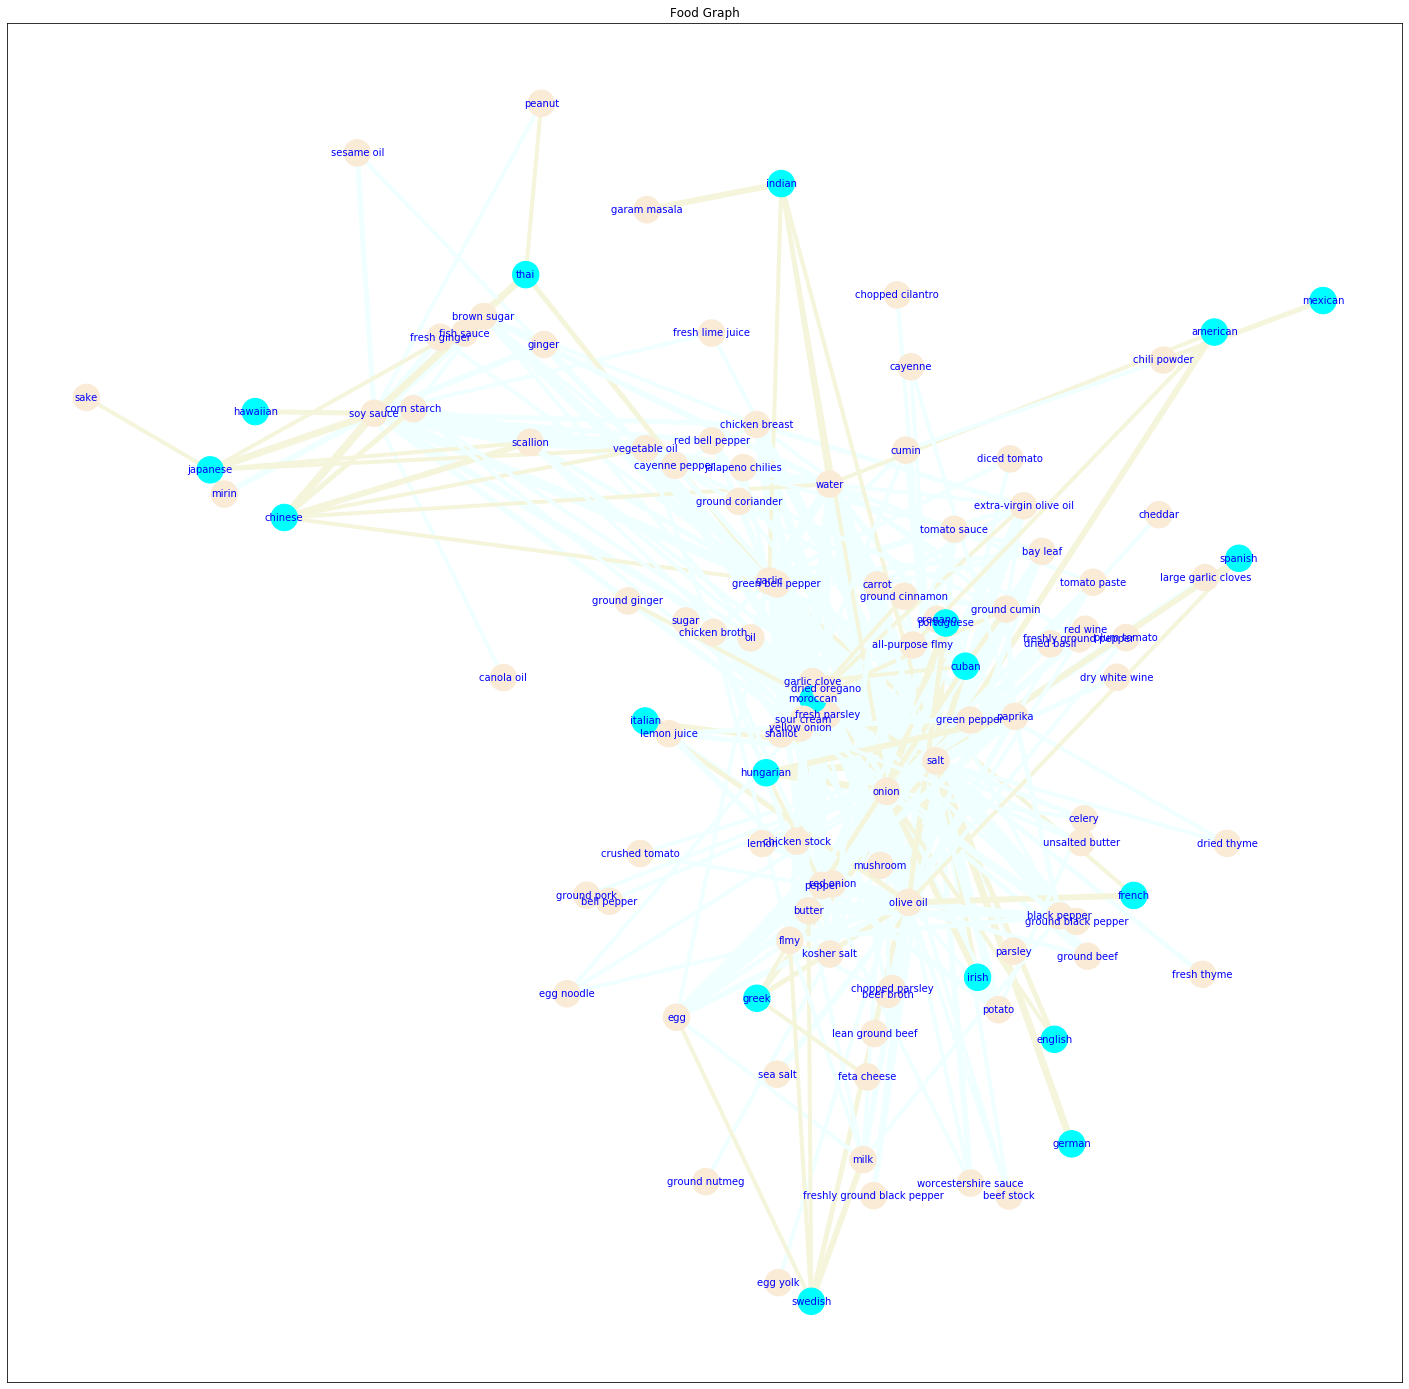

In [33]:
#SG = G.subgraph([n for n, attrdict in G.nodes(data=True) if attrdict['nodetype'] == 'recipe'])
SG = nx.Graph((u,v,d) for u,v,d in G.edges(data=True) if d['frequency'] > 3)

fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Food Graph")
#pos = graphviz_layout(G, prog='neato', args='') # https://networkx.github.io/documentation/stable/reference/drawing.html
pos = nx.spring_layout(G, scale=1)
#pos = nx.kamada_kawai_layout(G, scale=1)
#pos = nx.spectral_layout(G, scale=1)

nx.draw_networkx(SG, 
                 pos=pos, 
                 #arrows=True,
                 with_labels=True,
                 ax=ax,
                 nodelist=SG.nodes(),
                 edgelist=SG.edges(),
                 node_size=700,
                 node_color=[nx.get_node_attributes(G,'color')[g] for g in SG.nodes()],
                 node_shape='o',
                 alpha=1.0,
                 cmap=None,
                 vmin=None,
                 vmax=None,
                 linewidths=1.0,
                 width=list(nx.get_edge_attributes(SG,'frequency').values()),
                 edge_color=[nx.get_edge_attributes(SG,'color')[g] for g in SG.edges()],
                 edge_cmap=None,
                 edge_vmin=None,
                 edge_vmax=None,
                 style='solid',
                 labels=None ,
                 font_size=10,
                 font_color='blue',
                 font_weight='normal',
                 font_family='sans-serif',
                 label='Food Graph',)

In [34]:
#https://networkx.org/documentation/stable/reference/readwrite/json_graph.html
with open('../SampleDBs/food.json', 'w') as f:
    f.write(json.dumps(nx.cytoscape_data(SG)))

In [24]:
with open('../SampleDBs/food.json', 'r') as f:
    data = json.loads(f.read())
    
for element in data['elements']:
    print(element)

nodes
edges


In [ ]:
#https://dash.plotly.com/cytoscape
#https://github.com/plotly/dash-cytoscape
#https://medium.com/plotly/introducing-dash-cytoscape-ce96cac824e4
#https://github.com/plotly/dash-cytoscape/blob/master/demos/usage-concentric-social-network.py

import json
import dash
import urllib.request
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_cytoscape as cyto

app = dash.Dash(__name__)
app.title = "Food Graphs"
server = app.server

app.scripts.config.serve_locally = True
app.css.config.serve_locally = True


with open('./food.json', 'r') as f:
    data = json.loads(f.read())
    
#https://github.com/plotly/dash-cytoscape/blob/master/demos/data/edge-types/cy-style.json
with open('cy-style.json') as f:
    stylesheet = json.loads(f.read())

styles = {
    'container': {
        'position': 'fixed',
        'display': 'flex',
        'flex-direction': 'column',
        'height': '100%',
        'width': '100%'
    },
    'cy-container': {
        'flex': '1',
        'position': 'relative'
    },
    'cytoscape': {
        'position': 'absolute',
        'width': '100%',
        'height': '100%',
        'z-index': 999
    }
}


# App
app.layout = html.Div(style=styles['container'], children=[
    html.Div([
        html.Button("Responsive Toggle", id='toggle-button'),
        html.Div(id='toggle-text')
    ]),
    html.Div(className='cy-container', style=styles['cy-container'], children=[
        cyto.Cytoscape(
            id='cytoscape',
            elements=data['elements'],
            stylesheet=stylesheet,
            style=styles['cytoscape'],
            layout={
                'name': 'cose',
                'idealEdgeLength': 100,
                'nodeOverlap': 20,
                'refresh': 20,
                'fit': True,
                'padding': 30,
                'randomize': False,
                'componentSpacing': 100,
                'nodeRepulsion': 400000,
                'edgeElasticity': 100,
                'nestingFactor': 5,
                'gravity': 80,
                'numIter': 1000,
                'initialTemp': 200,
                'coolingFactor': 0.95,
                'minTemp': 1.0
            },
            responsive=True
        )
    ])
])


@app.callback(Output('cytoscape', 'responsive'), [Input('toggle-button', 'n_clicks')])
def toggle_responsive(n_clicks):
    n_clicks = 2 if n_clicks is None else n_clicks
    toggle_on = n_clicks % 2 == 0
    return toggle_on


@app.callback(Output('toggle-text', 'children'), [Input('cytoscape', 'responsive')])
def update_toggle_text(responsive):
    return '\t' + 'Responsive ' + ('On' if responsive else 'Off')

### Deployed [here](https://foodgraph.herokuapp.com/)

https://dashboard.heroku.com/apps/adagraphs/deploy/heroku-git  
https://devcenter.heroku.com/articles/heroku-cli#verifying-your-installation  
https://www.geeksforgeeks.org/deploy-python-flask-app-on-heroku/  

+ sudo snap install --classic heroku  
+ heroku login  
+ mkdir < project_name >  
+ cd < project_name >  
+ git init  
+ virtualenv venv  
+ source venv/bin/activate  
+ pip install dash  
+ pip install plotly  
+ pip install gunicorn  
+ pip install networkx  
+ pip install pandas  
+ pip install dash-cytoscape  

+ nano app.py  
+ nano .gitignore  
  venv  
  *.pyc  
  .DS_Store  
  .env  

+ nano Procfile  
  web: gunicorn app:server  

+ pip freeze > requirements.txt  

+ heroku login  
+ heroku create < project_name >    ---> https://< project_name >.herokuapp.com/  

# heroku git:remote -a <project_name>  
+ git add .  
+ git commit -m "first commit"   
+ git push heroku master  
+ heroku ps:scale web=1  


# Update the code and redeploy  

+ git status # view the changes  
+ git add .  # add all the changes  
+ git commit -m 'a description of the changes'  
+ git push heroku master  